# Практика

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

%matplotlib inline
print(tf.__version__)

2.12.0


In [2]:
#@title (вспомогательный код -- выполните клетку)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(discr_pred_fake_data):
    """
    discr_pred_fake_data -- предсказания дискриминатора на фейковых данных
    """
    labels = tf.ones_like(discr_pred_fake_data)
    # для генератора "хорошо", 
    # когда фейковые данные дискриминатор назвал реальными
    return cross_entropy(labels, discr_pred_fake_data) 

def discriminator_loss(disc_pred_real_data, disc_pred_fake_data):
    """
    disc_pred_real_data -- логиты, предсказанные дискриминатором для реальных данных
    disc_pred_fake_data -- логиты, предсказанные дискриминатором для фейковых данных
    """
    real_labels = tf.ones_like(disc_pred_real_data) # правильные ответ для реальных данных -- 1
    fake_labels = tf.zeros_like(disc_pred_fake_data) # правильные ответ для фейковых данных -- 0
    
    real_loss = cross_entropy(real_labels, disc_pred_real_data)
    fake_loss = cross_entropy(fake_labels, disc_pred_fake_data)

    total_loss = real_loss + fake_loss
    return total_loss

def generate_latent_points(latent_dim, n):
	x_input = np.random.randn(n,  latent_dim)
	return x_input

def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator.predict(x_input)
    return X

def show_result(generator, title=""):
    X_fake = generate_fake_samples(generator=generator, n=100)
    X_real = generate_real_samples(n=100)  
    plt.figure()
    plt.title(title)
    plt.scatter(X_real[:, 0], X_real[:, 1], label="real samples")
    plt.scatter(X_fake[:, 0], X_fake[:, 1], label="generated samples")
    plt.legend(loc="best")
    plt.show()

def train_step(discriminator, generator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)	
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Сэмплируем batch_size/2 точек из реального распределения
        X_real = generate_real_samples(n=half_batch)
        
        # генератор генерирует данные из латентных векторов, которые принадлежат простому распределению
        # и учится превращать их в распределени которое сможет обмануть дискриминатор
        # сначала генерируем латентные вектора -- 
        latent_z = np.random.randn(half_batch,  generator.input_shape[1])
        # а затем превращаем их с помощью генератора в X_fake
        X_fake = generator(latent_z)
        
        # 3. Делаем forward_pass дискриминатора на x_real и x_fake, 
        # получив discr_pred_real_data и discr_pred_fake_data
        discr_pred_real_data = discriminator(X_real)
        discr_pred_fake_data = discriminator(X_fake)

        # 4. Посчитать лосс дискриминатора и генератора
        disc_loss = discriminator_loss(discr_pred_real_data, discr_pred_fake_data)
        gen_loss = generator_loss(discr_pred_fake_data)
    
    # считаем производные
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # 5. Обновляем параметры генератора и дискриминатора. 
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return disc_loss.numpy(), gen_loss.numpy()

def train_gan(discriminator, generator, optimizer, n_epochs=10000, n_batch=128,
              show_every=1000):
    losses_hist_disc = []
    losses_hist_gen = []
    for i in tqdm(range(n_epochs)):
        if i % show_every == 0:
            show_result(generator=generator, title=f"Epoch {i}")
            
        disc_loss, gen_loss = train_step(discriminator, generator, optimizer, n_batch)
        losses_hist_disc.append(disc_loss)
        losses_hist_gen.append(gen_loss)
    return losses_hist_disc, losses_hist_gen

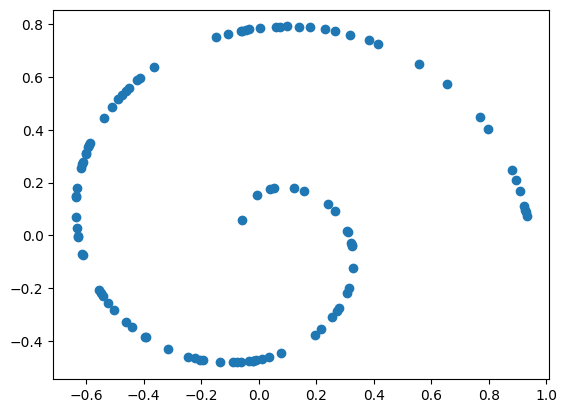

In [3]:
def spirals(n_points, noise=0):
    n = np.sqrt(np.random.rand(n_points, 1)) * 360*1.5 * (2*np.pi)/360
    dlx = -np.cos(n)*n + np.random.rand(n_points, 1) * noise
    dly = np.sin(n)*n + np.random.rand(n_points, 1) * noise
    return np.hstack((dlx, dly)) / 10.

def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(n, latent_dim)
    return x_input

def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator(x_input)
    return X

def generate_real_samples(n=100):
    return spirals(n_points=n, noise=0)

original = generate_real_samples(100)
plt.scatter(original[:, 0], original[:, 1])

Подберите архитектуру генератора и дискриминатора таким образом, чтобы научиться генерировать данные из указанного распределения.

In [4]:
def build_generator(latent_dim, n_outputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=latent_dim))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='tanh'))
    return model

def build_discriminator(n_inputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation='relu', input_dim=n_inputs))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

# вы можете изменить этот параметр
latent_dim = 10

generator = build_generator(latent_dim=latent_dim, n_outputs=2)
discriminator = build_discriminator(n_inputs=2)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=.001, beta_1=.5)

Metal device set to: Apple M2


  0%|                                                                                                        | 0/20000 [00:00<?, ?it/s]

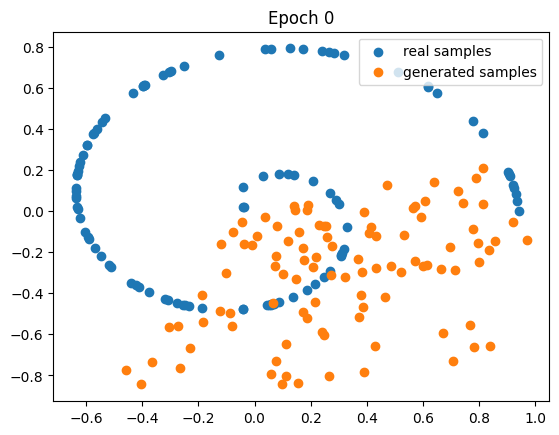

  5%|████▋                                                                                         | 999/20000 [01:03<19:27, 16.28it/s]

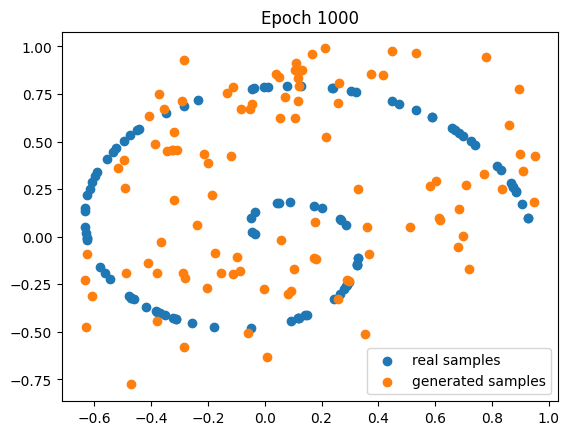

 10%|█████████▎                                                                                   | 1999/20000 [02:04<18:39, 16.08it/s]

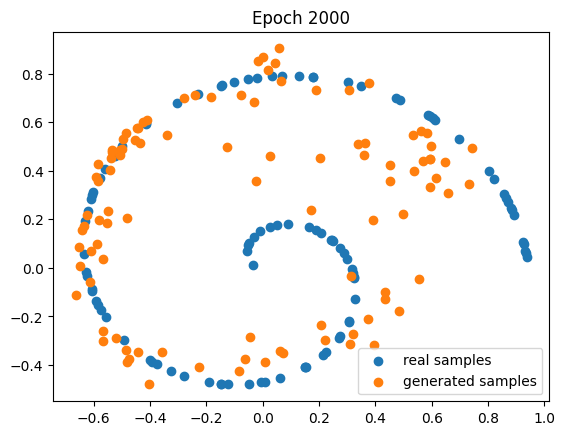

 15%|█████████████▉                                                                               | 2999/20000 [03:06<17:25, 16.25it/s]

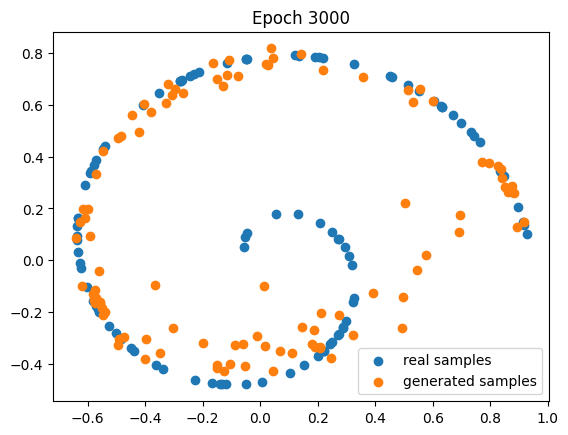

 20%|██████████████████▌                                                                          | 3999/20000 [04:09<16:59, 15.70it/s]

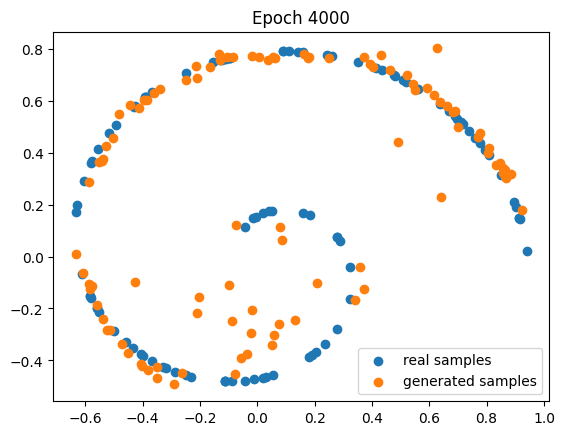

 25%|███████████████████████▏                                                                     | 4999/20000 [05:12<15:47, 15.84it/s]

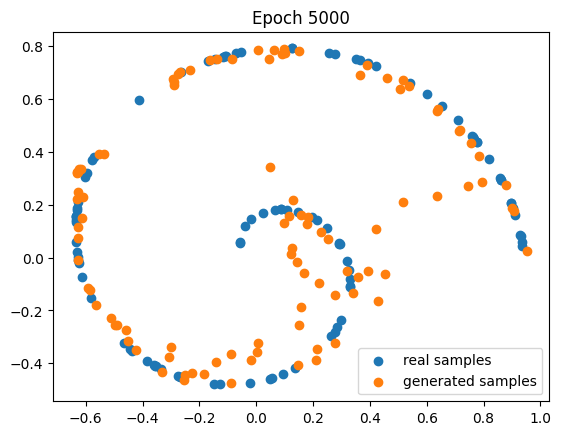

 30%|███████████████████████████▉                                                                 | 5999/20000 [06:15<15:39, 14.90it/s]

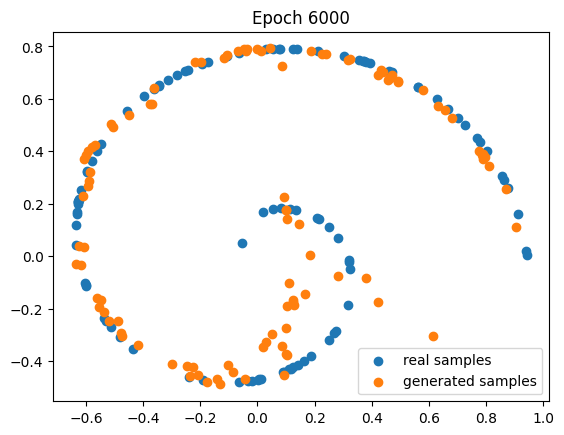

 35%|████████████████████████████████▌                                                            | 6999/20000 [07:18<14:23, 15.05it/s]

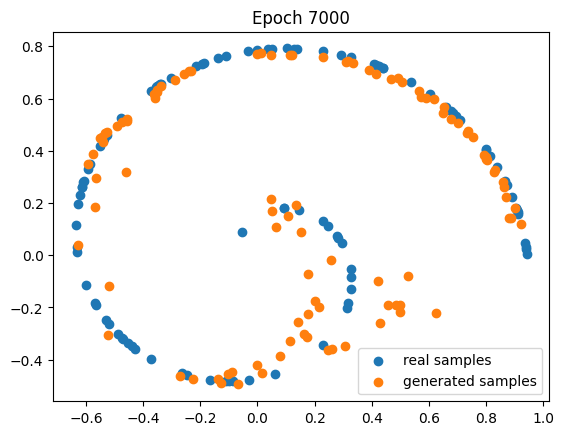

 40%|█████████████████████████████████████▏                                                       | 7999/20000 [08:20<12:38, 15.82it/s]

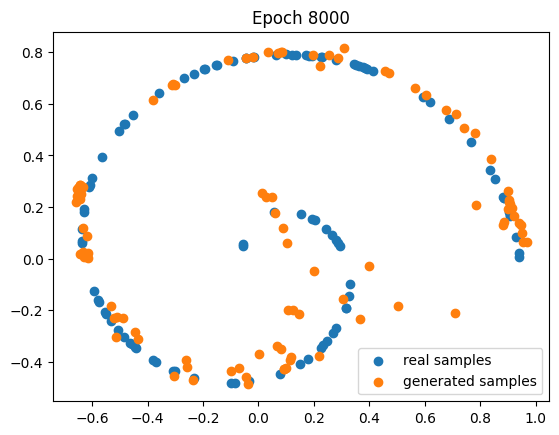

 45%|█████████████████████████████████████████▊                                                   | 8999/20000 [09:23<12:32, 14.62it/s]

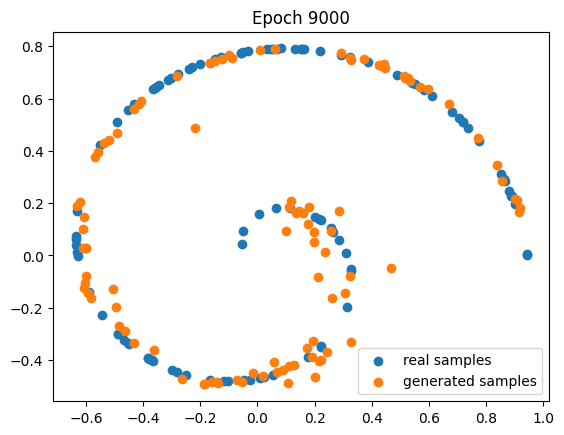

 50%|██████████████████████████████████████████████▍                                              | 9999/20000 [10:26<10:08, 16.43it/s]

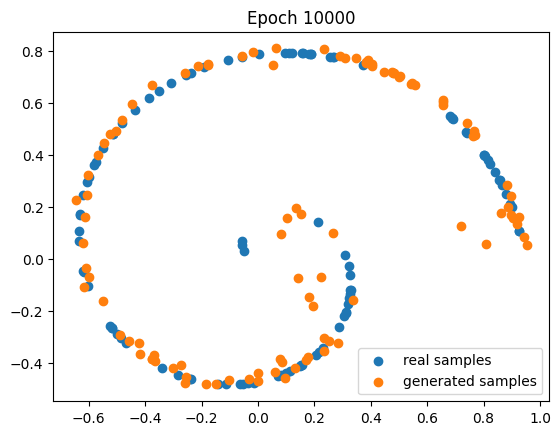

 55%|██████████████████████████████████████████████████▌                                         | 10999/20000 [11:29<09:24, 15.94it/s]

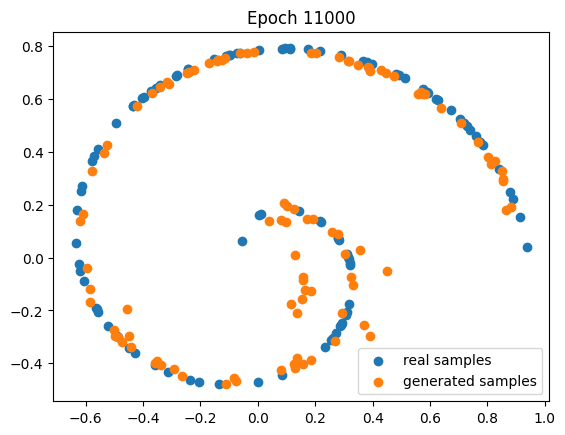

 60%|███████████████████████████████████████████████████████▏                                    | 11999/20000 [12:32<08:11, 16.29it/s]

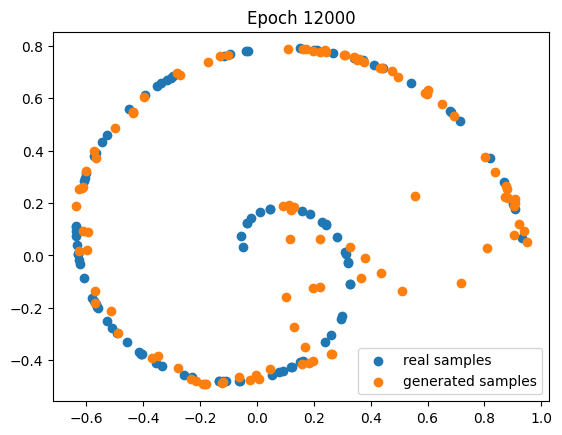

 65%|███████████████████████████████████████████████████████████▊                                | 13000/20000 [13:35<07:03, 16.53it/s]

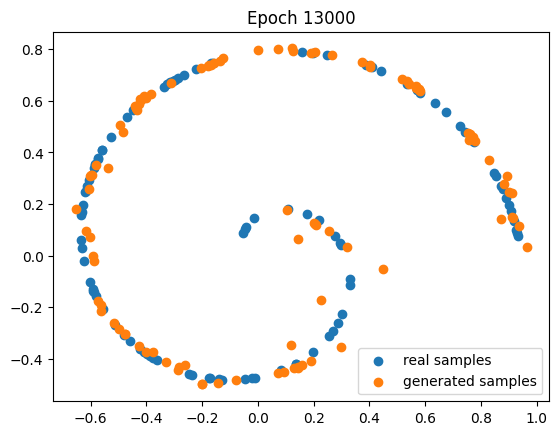

 70%|████████████████████████████████████████████████████████████████▍                           | 14000/20000 [14:37<06:11, 16.14it/s]

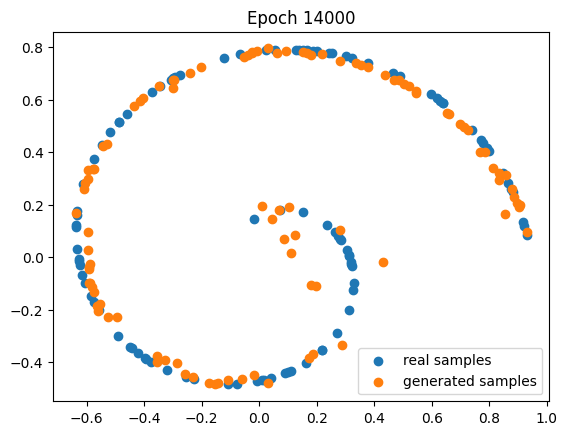

 75%|█████████████████████████████████████████████████████████████████████                       | 15000/20000 [15:40<05:30, 15.13it/s]

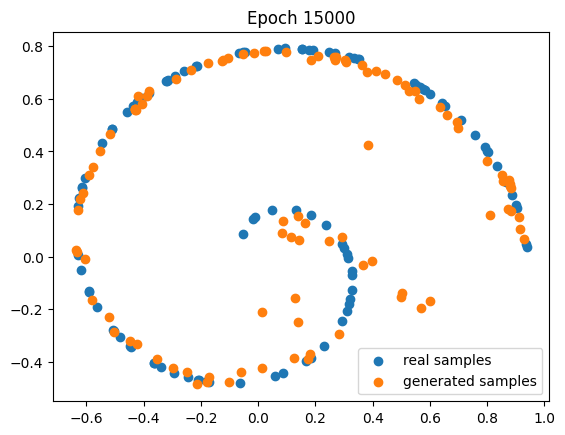

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 16000/20000 [16:43<04:02, 16.48it/s]

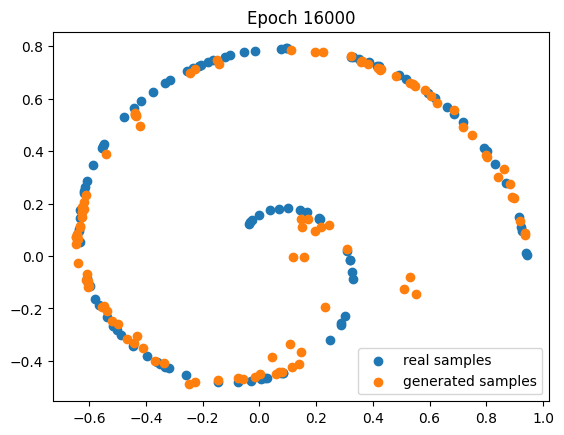

 85%|██████████████████████████████████████████████████████████████████████████████▏             | 17000/20000 [17:45<03:04, 16.30it/s]

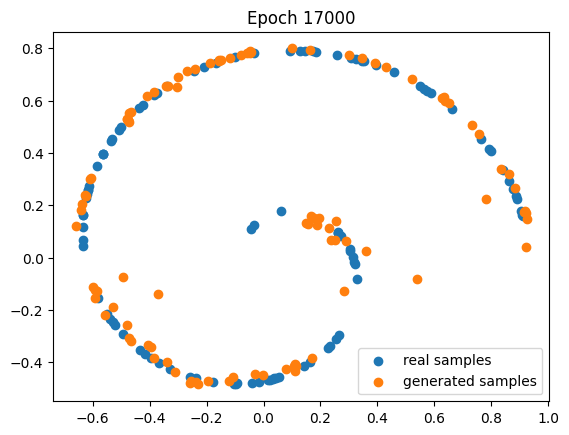

 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 18000/20000 [18:48<02:02, 16.30it/s]

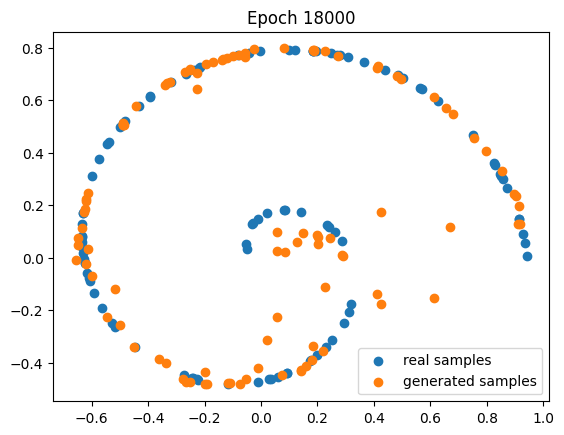

 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 19000/20000 [19:50<01:02, 15.98it/s]

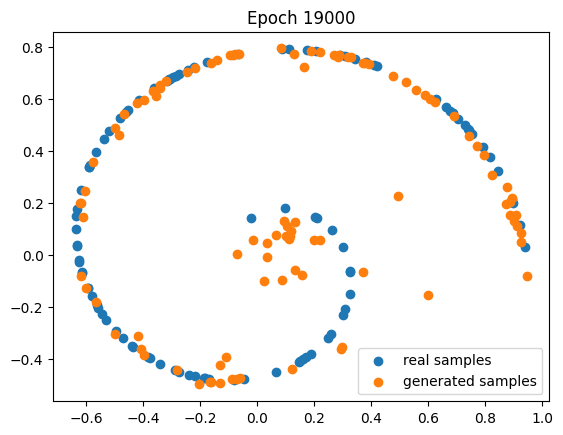

100%|████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [20:52<00:00, 15.96it/s]


In [5]:
losses_hist_disc, losses_hist_gen = train_gan(discriminator=discriminator, generator=generator, optimizer=optimizer, n_epochs=20000, show_every=1000)

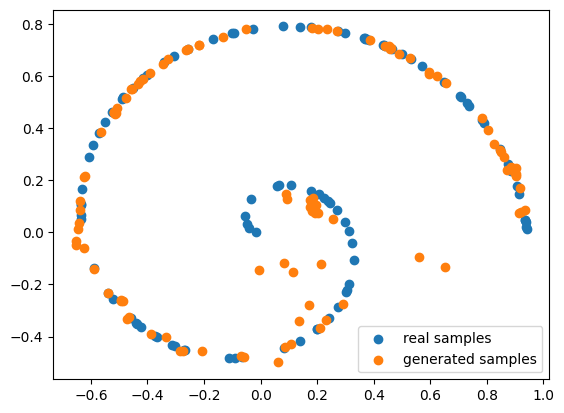

In [6]:
show_result(generator=generator)